# The baseline pipeline

The pipeline optimizes the predictive model for out-of-sample performance, fits the optimized model on the available training data, and evaluates its performance in-sample. 

In [1]:
import json
import functools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import time, datetime, timedelta
from feature_encoders.compose import ModelStructure
from feature_encoders.generate import DatetimeFeatures
from feature_encoders.models import LinearPredictor, GroupedPredictor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pd.plotting.register_matplotlib_converters()

In [2]:
from eensight.utils.jupyter import load_catalog
from eensight.pipelines.validate.metrics import cvrmse, nmbe
from eensight.features import ClusterFeatures, MMCFeatures
from eensight.pipelines.daytype import metric_function
from eensight.models import CompositePredictor, AggregatePredictor

In the *Design Principles* section, a general recipe for developing an ensemble of local linear models was presented:

 1.	Select the linear model to be used as the local estimator (i.e. the building block of the ensemble);
 2.	Define a way to quantify the notion of locality (distance metric), i.e. when two (2) observations are close enough to be handled by the same local model;
 3. Find a rule to assign all observations into neighborhoods of feature space;
 4. Fit one model per neighborhood;
 5. Predict using the average of all the models' predictions. If a test data point is outside the neighborhood of a model, that model does not contribute to the prediction. 
 
First, let's examine the structure of the local estimators.

## The local estimator

This section describes the simplest linear models that can be used as local estimators (base models) in `eensight`.

### The default local estimator

The details regarding the structure of the default base model can be found in the [documentation](https://feature-encoders.readthedocs.io/en/latest/tutorials.html) of the `feature-encoders` package. The `feature-encoders` package includes functionality that initially existed in `eensight` but became a separate package since it can be used independently of `eensight`. 

We can load the catalog and ask the configuration of a specific base model to be loaded too:

In [3]:
catalog = load_catalog('demo', partial_catalog=True, base_model='towt')

feature_map = catalog.load('feature_map')
model_config = catalog.load('model_config')

print(json.dumps(model_config, indent=4))

2021-11-18 16:58:52,538 - kedro.io.data_catalog - INFO - Loading data from `feature_map` (MemoryDataSet)...
2021-11-18 16:58:52,541 - kedro.io.data_catalog - INFO - Loading data from `model_config` (MemoryDataSet)...
{
    "add_features": {
        "time": {
            "type": "datetime",
            "subset": "month, hourofweek"
        }
    },
    "regressors": {
        "month": {
            "feature": "month",
            "type": "categorical",
            "encode_as": "onehot"
        },
        "tow": {
            "feature": "hourofweek",
            "type": "categorical",
            "encode_as": "onehot"
        },
        "lin_temperature": {
            "feature": "temperature",
            "type": "linear"
        },
        "flex_temperature": {
            "feature": "temperature",
            "type": "spline",
            "n_knots": 5,
            "degree": 1,
            "strategy": "uniform",
            "extrapolation": "constant",
            "interaction_only": t

We can apply the base model on all data:

In [4]:
data_train = catalog.load('train.model_input_data')

# We train the predictive models without outliers:
X_train = data_train.loc[~data_train['consumption_outlier']].drop(
            ['consumption', 'consumption_outlier'], axis=1
          )
y_train = data_train.loc[X_train.index, ['consumption']]

2021-11-18 16:58:56,030 - kedro.io.data_catalog - INFO - Loading data from `train.model_input_data` (CSVDataSet)...


Create the model:

In [5]:
model_structure = ModelStructure.from_config(model_config, feature_map)
local_model = LinearPredictor(model_structure=model_structure, alpha=0.01)

Fit on all available data:

In [6]:
%%time
local_model = local_model.fit(X_train, y_train)

Wall time: 2.84 s


Evaluate the model in-sample:

In [7]:
%%time
pred = local_model.predict(X_train)

Wall time: 377 ms


In [8]:
print(f"In-sample CV(RMSE) (%): {cvrmse(y_train[['consumption']], pred[['consumption']])*100}")
print(f"In-sample NMBE (%): {nmbe(y_train[['consumption']], pred[['consumption']])*100}")

In-sample CV(RMSE) (%): 14.886221293687132
In-sample NMBE (%): 5.950005779639545e-05


The effective number of parameters (i.e. the degrees of freedom) is:

In [9]:
local_model.dof

187

This is how the design matrix of the regression corresponds to each regressor:

In [10]:
local_model.composer_.component_matrix

component,lin_temperature,month,tow,tow:flex_temperature
col,,,,
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
184,0,0,0,1
185,0,0,0,1
186,0,0,0,1


This makes it easy to decompose the prediction into components (the regularization term `alpha=0.01` in the `LinearPredictor` was used primarily so that the individual components have reasonable values):

In [11]:
%%time

pred = local_model.predict(X_train, include_components=True)
pred.head()

Wall time: 469 ms


,consumption,lin_temperature,month,tow,tow:flex_temperature
timestamp,,,,,
2016-01-01 00:00:00,2051.387083,729.868302,600.409863,-995.524358,1716.633277
2016-01-01 00:15:00,2050.131838,726.013364,600.409863,-995.524358,1719.232970
2016-01-01 00:30:00,2048.876594,722.158426,600.409863,-995.524358,1721.832663
2016-01-01 00:45:00,2047.621349,718.303487,600.409863,-995.524358,1724.432357
2016-01-01 01:00:00,2174.654421,714.448549,600.409863,-867.236042,1727.032050


All components add up to the predicted consumption:

In [12]:
assert np.allclose(pred['consumption'],
            pred[[col for col in pred.columns if col != 'consumption']].sum(axis=1)
)

We can plot the standardized residuals, adding also the information about the **matrix profile scores**:

In [13]:
mp_scores = catalog.load('train.matrix_profile_scores')

discords = mp_scores[mp_scores['nnd'] >= mp_scores['nnd'].quantile(0.99)]
discords = data_train.loc[np.isin(data_train.index.date, discords.index.date)]

2021-11-18 16:59:14,646 - kedro.io.data_catalog - INFO - Loading data from `train.matrix_profile_scores` (CSVDataSet)...


In [14]:
resid = y_train[['consumption']] - pred[['consumption']]
resid = StandardScaler().fit_transform(resid).squeeze()
resid = pd.Series(data=resid, index=y_train.index)

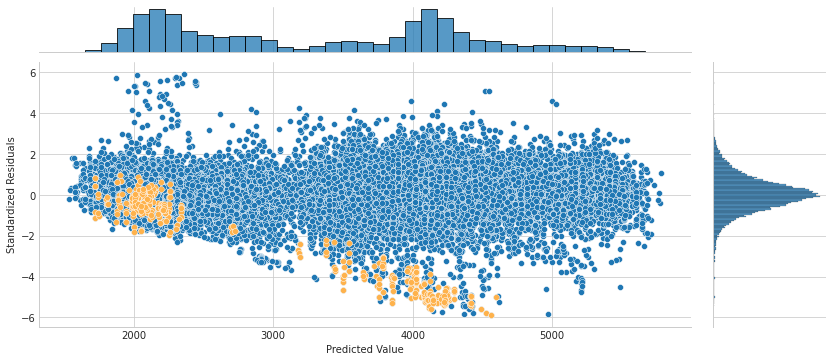

In [15]:
discord_resids = resid.loc[discords.index]

with plt.style.context('seaborn-whitegrid'):
    grid = sns.jointplot(x=pred['consumption'], y=resid)
    sns.scatterplot(x=pred.loc[discord_resids.index, 'consumption'], y=discord_resids, 
                    color='#feb24c', ax=grid.ax_joint)
    grid.fig.set_figwidth(12)
    grid.fig.set_figheight(5)
    grid.set_axis_labels(xlabel='Predicted Value', ylabel='Standardized Residuals')

Discords that are not handled well by the model are data subsets for which getting additional information will be most beneficial. In this case, all discords corespond to national holidays:

In [16]:
discords['holiday'].value_counts()

New year            96
Easter Monday       96
Christmas Day       96
St Stephen's Day    96
Name: holiday, dtype: int64

### The local estimator with holiday information

`eensight` includes a model specification for datasets with holiday information at *eensight/conf/base/models/towt_holidays.yaml*. This model adds to the `towt` model an intercation term between the holidays feature and the hour of the day, so that to correct the contribution of the hour of the week based on whether the day is a holiday or not:

In [17]:
catalog = load_catalog('demo', partial_catalog=True, base_model='towt_holidays')

model_config = catalog.load('model_config')
print(json.dumps(model_config, indent=4))

2021-11-18 16:59:24,368 - kedro.io.data_catalog - INFO - Loading data from `model_config` (MemoryDataSet)...
{
    "add_features": {
        "time": {
            "type": "datetime",
            "subset": "month, hourofweek, hour"
        }
    },
    "regressors": {
        "month": {
            "feature": "month",
            "type": "categorical",
            "encode_as": "onehot"
        },
        "tow": {
            "feature": "hourofweek",
            "type": "categorical",
            "encode_as": "onehot"
        },
        "hour": {
            "feature": "hour",
            "type": "categorical",
            "max_n_categories": 3,
            "encode_as": "onehot",
            "interaction_only": true
        },
        "holidays": {
            "feature": "holiday",
            "type": "categorical",
            "max_n_categories": 2,
            "excluded_categories": "_novalue_",
            "stratify_by": "hour",
            "min_samples_leaf": 1,
            "interact

This base model expects a `holiday` feature in the input data. We should check is this feature already exists and add a feature generator if it does not:

In [18]:
if "holiday" not in X_train.columns:
    location = catalog.load('location')
    if location and any(location.values()):
        model_config["add_features"].update(
            {'holidays': {'type': 'holidays', **location}}
        )
    else:
        raise ValueError("Cannot add holiday information because location is missing")

In [19]:
model_structure = ModelStructure.from_config(model_config, feature_map)
local_model = LinearPredictor(model_structure=model_structure, alpha=0.01)

In [20]:
%%time 

local_model = local_model.fit(X_train, y_train)
pred = local_model.predict(X_train)

print(f"In-sample CV(RMSE) (%): {cvrmse(y_train[['consumption']], pred[['consumption']])*100}")
print(f"In-sample NMBE (%): {nmbe(y_train[['consumption']], pred[['consumption']])*100}")

In-sample CV(RMSE) (%): 13.754676390008452
In-sample NMBE (%): 4.3880094936039377e-05
Wall time: 1.93 s


In [21]:
print('Number of parameters: {}'.format(local_model.n_parameters))
print('Degrees of freedom: {}'.format(local_model.dof))

Number of parameters: 198
Degrees of freedom: 193


In [22]:
resid = y_train[['consumption']] - pred[['consumption']]
resid = StandardScaler().fit_transform(resid).squeeze()
resid = pd.Series(data=resid, index=y_train.index)

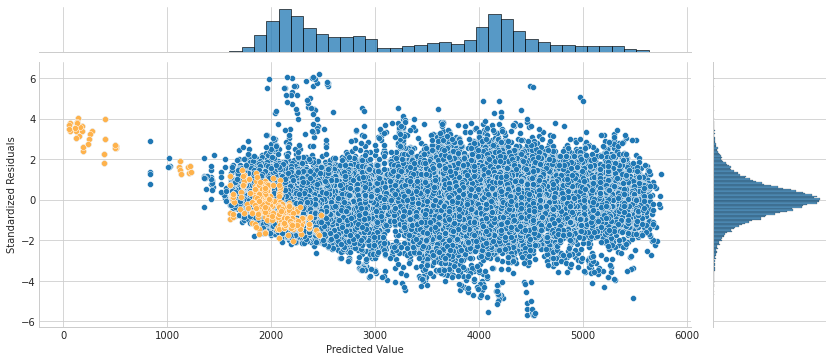

In [23]:
discord_resids = resid.loc[discords.index]

with plt.style.context('seaborn-whitegrid'):
    grid = sns.jointplot(x=pred['consumption'], y=resid)
    sns.scatterplot(x=pred.loc[discord_resids.index, 'consumption'], y=discord_resids, 
                    color='#feb24c', ax=grid.ax_joint)
    grid.fig.set_figwidth(12)
    grid.fig.set_figheight(5)
    grid.set_axis_labels(xlabel='Predicted Value', ylabel='Standardized Residuals')

## Using a distance metric

In the most general case, a base linear model can be applied on different clusters of the dataset. The clusters are generated using any given metric. Since each of the local models in the ensemble predicts on a different subset of the input data (an observation cannot belong to more than one clusters), the final prediction is generated by vertically concatenating all the individual models’ predictions:
 

<img src="images/grouped.png?modified=12345678" alt="grouped" width="600"/>


The distance metric that was estimated during the daytype pipeline is a valid metric that can be used for defining the clusters. The parameters of the clustering algorithm are optimized to maximize the out of-sample performance of the predictive model.

We have the `distance_metrics` in the catalog from the day typing stage:

In [24]:
distance_metrics = catalog.load('train.distance_metrics')

2021-11-18 16:59:49,246 - kedro.io.data_catalog - INFO - Loading data from `train.distance_metrics` (PickleDataSet)...


Select a time interval:

In [25]:
interval = 0

start_time = distance_metrics[interval]['start_time']
end_time = distance_metrics[interval]['end_time']

if end_time is None:
    end_time = (
        datetime.combine(
            datetime.now().date(), distance_metrics[0]["start_time"]
        )
        - timedelta(seconds=1)
    ).time()

In [26]:
metric_components = distance_metrics[interval]['metric_components']
metric = functools.partial(metric_function, metric_components)

In [27]:
mcc_features = Pipeline([
        ('dates', DatetimeFeatures(subset=['month', 'dayofweek'])),
        ('features', MMCFeatures()),
])

In [28]:
clusterer = ClusterFeatures(eps=0.5, 
                            transformer=mcc_features, 
                            output_name='cluster', 
                            metric=metric)

In [29]:
model_grouped = GroupedPredictor(
        group_feature='cluster',
        model_conf=model_config, 
        feature_conf=feature_map,
        estimator_params=(('alpha', 0.01), ('fit_intercept', False)),
)

Get the relevant subset in the interval:

In [30]:
X_train_int = X_train.between_time(start_time, end_time, include_end=False)
y_train_int = y_train.between_time(start_time, end_time, include_end=False)

In [31]:
clusters = clusterer.fit_transform(X_train_int)

X_train_int_clusters = pd.concat((X_train_int, clusters), axis=1)

In [32]:
%%time
model_grouped = model_grouped.fit(X_train_int_clusters, y_train_int)

Wall time: 1.35 s


The `GroupedPredictor` applies the feature generation transformers defined in `model_conf` directly on the dataset before it is split per cluster:

In [33]:
model_grouped.added_features_

[DatetimeFeatures(subset=['month', 'hourofweek', 'hour'])]

In addition, it fits all categorical encoders in ordinal form, and passes the encoded data (but not the actual encoders) to each cluster estimator:

In [34]:
for name, encoder in model_grouped.encoders_['main_effects'].items():
    print('--->', name)
    print(encoder)

---> month
CategoricalEncoder(encode_as='ordinal', feature='month')
---> tow
CategoricalEncoder(encode_as='ordinal', feature='hourofweek')


... and adds the `cluster` feature in every `stratify_by` that is not empty:

In [35]:
for pair_name, encoder in model_grouped.encoders_['interactions'].items():
    print('--->', pair_name)
    print(encoder)

---> ('hour', 'holidays')
{'hour': CategoricalEncoder(encode_as='ordinal', feature='hour', max_n_categories=3), 'holidays': CategoricalEncoder(encode_as='ordinal', excluded_categories=['_novalue_'],
                   feature='holiday', max_n_categories=2,
                   stratify_by=['cluster', 'hour'])}
---> ('tow', 'flex_temperature')
{'tow': CategoricalEncoder(encode_as='ordinal', feature='hourofweek',
                   max_n_categories=2, min_samples_leaf=15,
                   stratify_by=['cluster', 'temperature'])}


Evaluate the model in-sample:

In [36]:
%%time
pred = model_grouped.predict(X_train_int_clusters)

Wall time: 431 ms


In [37]:
y_true = y_train_int

print(f"In-sample CV(RMSE) (%): {cvrmse(y_true[['consumption']], pred[['consumption']])*100}")
print(f"In-sample NMBE (%): {nmbe(y_true[['consumption']], pred[['consumption']])*100}")

In-sample CV(RMSE) (%): 11.682465565557864
In-sample NMBE (%): 0.0002145365581858405


The number of parameters was:

In [38]:
model_grouped.n_parameters

157

the degrees of freedom:

In [39]:
model_grouped.dof

147

The process of combining distance metrics per time interval, clusters and base models is encapsulated into the `eensight.models.CompositePredictor`:

In [40]:
model = CompositePredictor(
    group_feature='cluster',
    distance_metric=metric, 
    base_clusterer=clusterer,
    base_regressor=model_grouped
)

In [41]:
%%time
model = model.fit(X_train_int, y_train_int)

2021-11-18 17:00:13,822 - model-training - WARNING - Model is being fitted without explicit clustering parameters
Wall time: 1.38 s


In [42]:
%%time
pred = model.predict(X_train_int)

Wall time: 491 ms


In [43]:
y_true = y_train_int

print(f"In-sample CV(RMSE) (%): {cvrmse(y_true[['consumption']], pred[['consumption']])*100}")
print(f"In-sample NMBE (%): {nmbe(y_true[['consumption']], pred[['consumption']])*100}")

In-sample CV(RMSE) (%): 11.682465565557864
In-sample NMBE (%): 0.0002145365581994637


In [44]:
print('Number of parameters: {}'.format(model.n_parameters))
print('Degrees of freedom: {}'.format(model.dof))

Number of parameters: 157
Degrees of freedom: 147


The `eensight.models.AggregatePredictor` does the splitting of the data into the intervals for us:

In [45]:
model = AggregatePredictor(   
    distance_metrics=distance_metrics,
    base_clusterer=ClusterFeatures(
        transformer=mcc_features,
        output_name='cluster',
        n_jobs=1
    ),
    base_regressor=GroupedPredictor(
        model_conf=model_config,
        feature_conf=feature_map,
        group_feature='cluster',
        estimator_params=(
            ("alpha", 0.01),
            ("fit_intercept", False),
        ),
    ),
    group_feature='cluster',
)

This model is optimized and applied on the whole dataset:

In [46]:
%%time

opt_cluster_params = model.optimize(X_train, y_train, n_jobs=-1)
model = model.set_params(cluster_params=opt_cluster_params)

Wall time: 2min 14s


In [47]:
%%time
model = model.fit(X_train, y_train)

Wall time: 16.3 s


In [48]:
%%time
pred = model.predict(X_train)

Wall time: 6.74 s


In [49]:
print(f"In-sample CV(RMSE) (%): {cvrmse(y_train[['consumption']], pred[['consumption']])*100}")
print(f"In-sample NMBE (%): {nmbe(y_train[['consumption']], pred[['consumption']])*100}")

In-sample CV(RMSE) (%): 12.477618573375983
In-sample NMBE (%): 0.00020815561678281142


In [50]:
print('Number of parameters: {}'.format(model.n_parameters))
print('Degrees of freedom: {}'.format(model.dof))

Number of parameters: 785
Degrees of freedom: 725


The components of the prediction propagate from the individual models:

In [52]:
%%time

pred = model.predict(X_train, include_components=True)
pred.head()

Wall time: 7.33 s


,consumption,hour:holidays,lin_temperature,month,tow,tow:flex_temperature
timestamp,,,,,,
2016-01-01 00:00:00,1885.879796,443.110469,370.754105,555.863854,224.247342,291.904027
2016-01-01 00:15:00,1884.278221,443.110469,368.795897,555.863854,224.247342,292.260660
2016-01-01 00:30:00,1882.676646,443.110469,366.837689,555.863854,224.247342,292.617293
2016-01-01 00:45:00,1881.075071,443.110469,364.879480,555.863854,224.247342,292.973926
2016-01-01 01:00:00,1916.438004,377.529495,362.921272,555.863854,54.995256,565.128127


All components add up to the predicted consumption:

In [53]:
assert np.allclose(
        pred['consumption'],
        pred[[col for col in pred.columns if col != 'consumption']].sum(axis=1)
)

## Save to the catalog

In [54]:
catalog.save('mean_model', model)

2021-11-18 17:04:27,263 - kedro.io.data_catalog - INFO - Saving data to `mean_model` (PickleDataSet)...


-----------------